In [14]:
import numpy as np
import marshal, json
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import matplotlib.patches as patches
import matplotlib
import json, math
from operator import sub
import scipy.stats
from IPython.display import set_matplotlib_formats
from IPython.display import Image
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({
    'font.family': 'serif',
    "font.serif": 'Times',
    'font.size': 12,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.latex.preamble': r'\usepackage{amsmath}'
})

########## PARAMS ##########
num_runs = 20
diss_rate_target = 0.99
aoi_target = 0.01
v = 43
frame_count = 5

density_low = 4.59598735
density_high = 11.95521146

q_list = [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
p_list = [100, 95, 90, 85, 80, 75, 70, 65, 60, 55, 50]
i_list = [30, 60, 90, 120, 150, 180, 210, 240, 270]

AT = 36 * 180

nn = np.arange(100, 800, 25)

########## UTIL FUNCTIONS ##########

def get_aspect(ax):
    # Total figure size
    figW, figH = ax.get_figure().get_size_inches()
    # Axis size on figure
    _, _, w, h = ax.get_position().bounds
    # Ratio of display units
    disp_ratio = (figH * h) / (figW * w)
    # Ratio of data units
    # Negative over negative because of the order of subtraction
    data_ratio = sub(*ax.get_ylim()) / sub(*ax.get_xlim())

    return disp_ratio / data_ratio

def calculate_confidence_interval(data, confidence=.99):
    n = len(data)
    m = np.mean(data)
    std_dev = scipy.stats.sem(data)
    h = std_dev * scipy.stats.t.ppf((1 + confidence) / 2, n - 1)
    return [m, h]

def cis_overlap(l_1, h_1, l_2, h_2):
    return (l_1 >= l_2 and l_1 <= h_2) or (h_1 >= l_2 and h_1 <= h_2)

def is_successful_config(diss_rate, excess_probability, config):
    return diss_rate[config] >= diss_rate_target and excess_probability[config] <= aoi_target


def get_best_config(diss_rate, excess_probability, diss_rate_ci):
    meets_reliability_target = len(diss_rate[diss_rate >= diss_rate_target]) > 0
    if meets_reliability_target:
        candidates = diss_rate >= diss_rate_target
        candidates = (1 - excess_probability) * candidates
        return np.unravel_index(np.argmax(candidates), candidates.shape)
    else:
        candidates = excess_probability <= aoi_target
        candidates = diss_rate * candidates
        best = np.unravel_index(np.argmax(candidates), candidates.shape)
        return best

def get_rdf_config_performance(n,i,q):
    diss_rate = []
    excess_probability = []
    txd = []

    D =  math.sqrt(n/12)
    T = (D*1000) / 33.3
    AT = D*D*T

    errors = 0
    for r in range(num_runs):
        try:
            with open(f'../res/v{v}_parsed/summary_kpi_rdf_n{n}_i{i}_q{q}_r{r}.json', 'r') as f:
                data = json.load(f)
                diss_rate.append(data['avg_dissemination_rate'])
                excess_probability.append(data['excess_probability_1_R_peak'])
                txd.append((data['num_sent'] + data['num_fwd']) / AT)
        except:
            errors += 1

    if errors == num_runs:
        return (0, 1, 0 ,0, 0, 0)

    (avg_diss_rate, diss_rate_ci) = calculate_confidence_interval(diss_rate)
    (excess_probability, excess_probability_ci) = calculate_confidence_interval(excess_probability)
    (avg_txd, txd_ci) = calculate_confidence_interval(txd)
    return (avg_diss_rate, excess_probability, diss_rate_ci, excess_probability_ci, avg_txd, txd_ci)


def get_sf_config_performance(n,i,p):
    diss_rate = []
    excess_probability = []
    txd = []

    errors = 0
    for r in range(num_runs):
        try:
            with open(f'../res/v{v}_parsed/summary_kpi_sf_n{n}_i{i}_p{p}_r{r}.json', 'r') as f:
                data = json.load(f)
                diss_rate.append(data['avg_dissemination_rate'])
                excess_probability.append(data['excess_probability_1_R_peak'])
                txd.append((data['num_sent'] + data['num_fwd']) / AT)
        except:
            errors += 1

    if errors == num_runs:
        return (0, 1, 0 ,0, 0, 0)

    (avg_diss_rate, diss_rate_ci) = calculate_confidence_interval(diss_rate)
    (excess_probability, excess_probability_ci) = calculate_confidence_interval(excess_probability)
    (avg_txd, txd_ci) = calculate_confidence_interval(txd)
    return (avg_diss_rate, excess_probability, diss_rate_ci, excess_probability_ci, avg_txd, txd_ci)

In [15]:
rdf_txds = []
rdf_txds_invalid = []
rdf_configs = []
for n in nn:
    txd = []
    txdi = []
    config = []

    for i in i_list:
        for q in q_list:
            (dr, ep, dr_ci, ep_ci, traffic_density, txd_ci) = get_rdf_config_performance(n, i, q)
            if dr >= diss_rate_target and ep <= aoi_target:
                txd.append(traffic_density)
                config.append((i,q))
            else:
                txdi.append(traffic_density)



    rdf_txds.append(txd)
    rdf_txds_invalid.append(txdi)
    rdf_configs.append(config)

sf_txds = []
sf_configs = []
for n in nn:
    txd = []
    config = []

    for i in i_list:
        for p in p_list:
            (dr, ep, dr_ci, ep_ci, traffic_density, txd_ci) = get_sf_config_performance(n, i, p)
            if dr >= diss_rate_target and ep <= aoi_target:
                txd.append(traffic_density)
                config.append((i,q))


    sf_txds.append(txd)
    sf_configs.append(config)


In [16]:
def get_rdf_performance(num_nodes):
    reliability_target = np.zeros((len(q_list), len(i_list)))
    delay_target = np.zeros((len(q_list), len(i_list)))
    reliability_target_ci = np.zeros((len(q_list), len(i_list)))
    delay_target_ci = np.zeros((len(q_list), len(i_list)))
    txd = np.zeros((len(q_list), len(i_list)))
    txd_ci = np.zeros((len(q_list), len(i_list)))

    for x, q in enumerate(q_list):
        for y, i in enumerate(i_list):
            (diss_rate, excess_probability, diss_rate_ci, excess_probability_ci, traffic_density, traffic_density_ci) = get_rdf_config_performance(num_nodes, i, q)
            reliability_target[x][y] = diss_rate
            delay_target[x][y] = excess_probability
            reliability_target_ci[x][y] = diss_rate_ci
            delay_target_ci[x][y] = excess_probability_ci
            txd[x][y] = traffic_density
            txd_ci[x][y] = traffic_density_ci

    return (reliability_target, delay_target, reliability_target_ci, delay_target_ci, txd, txd_ci)

def get_sf_performance(num_nodes):
    reliability_target = np.zeros((len(q_list), len(i_list)))
    delay_target = np.zeros((len(q_list), len(i_list)))
    reliability_target_ci = np.zeros((len(q_list), len(i_list)))
    delay_target_ci = np.zeros((len(q_list), len(i_list)))
    txd = np.zeros((len(q_list), len(i_list)))
    txd_ci = np.zeros((len(q_list), len(i_list)))

    for x, p in enumerate(p_list):
        for y, i in enumerate(i_list):
            (diss_rate, excess_probability, diss_rate_ci, excess_probability_ci, traffic_density, traffic_density_ci) = get_sf_config_performance(num_nodes, i, p)
            reliability_target[x][y] = diss_rate
            delay_target[x][y] = excess_probability
            reliability_target_ci[x][y] = diss_rate_ci
            delay_target_ci[x][y] = excess_probability_ci
            txd[x][y] = traffic_density
            txd_ci[x][y] = traffic_density_ci

    return (reliability_target, delay_target, reliability_target_ci, delay_target_ci, txd, txd_ci)
    

def get_metrics(get_performance_fkt, get_best_fkt=get_best_config):
    ep = []
    dr = []
    txd = []
    txd_ci = []
    ep_ci = []
    dr_ci = []
    trajectory = []

    for n in nn:
        (reliability_target, delay_target, reliability_target_ci, delay_target_ci, traffic_density, traffic_density_ci) = get_performance_fkt(n)
        best = get_best_fkt(reliability_target, delay_target, reliability_target_ci)
        if len(trajectory) >= 1:
            last_config = trajectory[-1]
            rtl = reliability_target[last_config]
            rtl_ci = reliability_target_ci[last_config]
            rtb = reliability_target[best]
            rtb_ci = reliability_target_ci[best]
            dtl = delay_target[last_config]
            dtl_ci = delay_target_ci[last_config]
            dtb = delay_target[best]
            dtb_ci = delay_target_ci[best]

            rtl_met = rtl >= diss_rate_target
            rtb_met = rtb >= diss_rate_target
            dtl_met = dtl <= aoi_target
            dtb_met = dtb <= aoi_target
            l_met = rtl_met and dtl_met
            b_met = dtb_met and rtb_met
            
            # Both CIs overlap, we can use the old one
            if (b_met == l_met) and cis_overlap(rtl-rtl_ci, rtl+rtl_ci, rtb-rtb_ci, rtb+rtb_ci) and cis_overlap(dtl-dtl_ci, dtl+dtl_ci, dtb-dtb_ci, dtb+dtb_ci):
                print('CHANGE', best, last_config)
                best = last_config

            # The Diss rate CI overlaps, and the old one is actually better
            if (b_met == l_met) and cis_overlap(rtl-rtl_ci, rtl+rtl_ci, rtb-rtb_ci, rtb+rtb_ci) and dtl <= dtb:
                print('CHANGE', best, last_config)
                best = last_config

            # No targets met but diss rates overlap
            if (not rtl_met) and (not rtb_met) and cis_overlap(rtl-rtl_ci, rtl+rtl_ci, rtb-rtb_ci, rtb+rtb_ci):
                print('CHANGE', best, last_config)
                best = last_config

            if (not dtl_met) and (not dtb_met) and rtl_met and rtb_met and cis_overlap(dtl-dtl_ci, dtl+dtl_ci, dtb-dtb_ci, dtb+dtb_ci):
                print('CHANGE', best, last_config)
                best = last_config

        trajectory.append(best)
        ep.append(delay_target[best] * 100)
        dr.append(reliability_target[best] * 100)
        txd.append(traffic_density[best])
        txd_ci.append(traffic_density_ci[best])
        ep_ci.append(delay_target_ci[best] * 100)
        dr_ci.append(reliability_target_ci[best] * 100)

    ep = np.array(ep)
    dr = np.array(dr)
    ep_ci = np.array(ep_ci)
    dr_ci = np.array(dr_ci)
    txd = np.array(txd)
    txd_ci = np.array(txd_ci)
    return (ep, dr, ep_ci, dr_ci, trajectory, txd, txd_ci)


(sf_ep, sf_dr, sf_ep_ci, sf_dr_ci, sf_trajectory, sf_txd, sf_txd_ci) = get_metrics(get_sf_performance)
(rdf_ep, rdf_dr, rdf_ep_ci, rdf_dr_ci, rdf_trajectory, rdf_txd, rdf_txd_ci) = get_metrics(get_rdf_performance)


CHANGE (10, 3) (10, 3)
CHANGE (10, 3) (10, 3)
CHANGE (10, 5) (10, 4)
CHANGE (10, 4) (10, 4)
CHANGE (10, 7) (9, 5)
CHANGE (8, 7) (9, 7)
CHANGE (9, 7) (9, 7)
CHANGE (7, 7) (9, 7)
CHANGE (2, 7) (5, 7)
CHANGE (0, 7) (5, 7)
CHANGE (8, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (8, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHANGE (9, 3) (9, 3)
CHAN

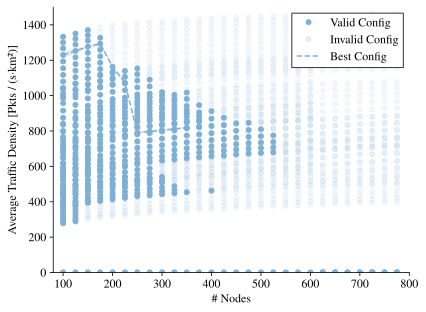

In [20]:
rdf_color = '#7eb0d5'
sf_color = '#fd7f6f'

ms = 10
density_low = 4.59598735
density_high = 11.95521146

sf_reduction = []
rdf_reduction = []

fig, ax = plt.subplots()

connected_at = 1.44 * (6 / 0.509)**2

# ax.fill_between([density_low*36, connected_at], [0,0], [7000, 7000], facecolor='#ebebeb', interpolate=True, clip_on=True, hatch='\\\\', ec='#fff', lw=0)
# ax.fill_between([connected_at, density_high* 36], [0,0], [7000, 7000], facecolor='#ebebeb', interpolate=True, clip_on=True)
# ax.text(density_high * 36, 1100 * 1.04, "DOOLE REGION",  ha="right", va="top", color='#333', fontsize=10)
for i, arr in enumerate(rdf_txds_invalid):
    if len(arr) > 0:
        mn = min(arr)
        mx =  max(arr)
        #ax.plot([nn[i], nn[i]], [mn, mx], color=rdf_color, lw=1)
        ax.plot([nn[i]] * len(arr), arr, '.', color=rdf_color, ms=ms, alpha=0.1)
        idx = np.argmin(arr)
        reduction_vs_best = (rdf_txd[i] - mn) / rdf_txd[i]
        rdf_reduction.append(reduction_vs_best)

for i, arr in enumerate(rdf_txds):
    if len(arr) > 0:
        mn = min(arr)
        mx =  max(arr)
        #ax.plot([nn[i], nn[i]], [mn, mx], color=rdf_color, lw=1)
        ax.plot([nn[i]] * len(arr), arr, '.', color=rdf_color, ms=ms)
        idx = np.argmin(arr)
        reduction_vs_best = (rdf_txd[i] - mn) / rdf_txd[i]
        rdf_reduction.append(reduction_vs_best)

for i, arr in enumerate(sf_txds):
    if len(arr) > 0:
        mn = min(arr)
        mx =  max(arr)
        #ax.plot([nn[i], nn[i]], [min(arr), max(arr)], color=sf_color, lw=1)
        # ax.plot([nn[i]] * len(arr), arr, '.', color=sf_color, ms=ms)
        idx = np.argmin(arr)
        # print(sf_configs[i][idx])
        # print(nn[i], f'{(mx - mn) * 100 / mx:.2f}')
        reduction_vs_best = (sf_txd[i] - mn) / sf_txd[i]
        sf_reduction.append(reduction_vs_best)

# ax.plot(nn, sf_txd, '--', color=sf_color)
# ax.fill_between(nn, sf_txd - sf_txd_ci, sf_txd + sf_txd_ci, facecolor=sf_color, interpolate=True, alpha=0.2)
ax.plot(nn[0:11], rdf_txd[0:11], '--', color=rdf_color)
ax.fill_between(nn[0:11], rdf_txd[0:11] - rdf_txd_ci[0:11], rdf_txd[0:11] + rdf_txd_ci[0:11], facecolor=rdf_color, interpolate=True, alpha=0.2)

ax.plot(-1,-1, '.', color=rdf_color, label='Valid Config', ms=ms)
ax.plot(-1,-1, '.', color=rdf_color, label='Invalid Config', ms=ms, alpha = 0.2)
# ax.plot(-1,-1, '.', color=sf_color, label='PF / SF', ms=ms)
ax.plot(-1,-1, '--', color=rdf_color, label='Best Config')
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.set_ylim(0, 1500)
ax.set_xlim(80, 800)

leg = plt.legend(fancybox=False, loc='upper right', framealpha=1.0)
leg.get_frame().set_edgecolor('#333')
plt.ylabel('Average Traffic Density [Pkts / (s$\cdot$km²)]')
plt.xlabel('\# Nodes')
fig.savefig(f"../figures/txd_reduction_v{v}.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
fig.savefig(f"../figures/txd_reduction_v{v}.png", dpi=500, bbox_inches='tight', pad_inches=0.01)
plt.show()

# print(np.mean(sf_reduction), np.max(sf_reduction))
# print(np.mean(rdf_reduction), np.max(rdf_reduction))

In [18]:
print(np.sum([len(a) for a in rdf_txds])/ len([x for x in rdf_txds if len(x) > 0]))
print(np.sum([len(a) for a in sf_txds])/ len([x for x in sf_txds if len(x) > 0]))

26.38888888888889
15.4


In [19]:
print(sf_reduction)

[0.39221196054948027, 0.265999102889863, 0.15659930786395088, 0.15389838990044422, 0.07232464009426892]
